# Import Packages

In [1]:
# Import packages
import random
import math
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import resample
from scipy.stats import beta, f_oneway, kruskal, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

# Algorithms 
* Without tuning
 * Epsilon Decay
 * Annealing Softmax
 * UCB1
 * Bayesian UCB
 * Thompson Sampling
* With Tuning
 * Epsilon Greedy
 * Softmax

## Algorithms Without Tuning
* Epsilon Decay
* Annealing Softmax
* UCB1
* Bayesian UCB
* Thompson Sampling

### Epsilon Decay

In [2]:
def epsilon_decay(history, arms):
    
    epsilon = 1 / (sum(history["count"]) / len(arms) + 1)
    
    if random.random() > epsilon: # exploit
        ranks = history.sort_values(by = ['mean'], ascending = False) 
        chosen_arm = ranks.iloc[0]['arm']
    else: # explore
        chosen_arm = np.random.choice(arms, replace = False)
    
    return chosen_arm

### Annealing Softmax

In [3]:
def annealing_softmax(history, arms):
    
    temp = 1 / (sum(history["count"]) / len(arms) + 1)

    z = sum([np.exp(v / temp) for v in history["mean"]])
    pi = [np.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### UCB1 (CHECK)

In [4]:
def ucb1(history, arms):

    n_arms = len(arms)
    
    for arm in range(n_arms):
        if int(history["count"][arm]) == 0:
            chosen_arm = history["arm"][arm]
            return chosen_arm
    
    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(history["count"])
    
    for arm in range(n_arms):
        bonus = math.sqrt((2*math.log(total_counts)) / (float(history["count"][arm])))
        ucb_values[arm] = history["mean"][arm] + bonus
    
    chosen_arm = ucb_values.index(max(ucb_values)) + 1
    
    return chosen_arm

### Bayesian UCB (CHECK)

In [5]:
def bayesian_ucb(history, arms):
    
    n_arms = len(arms)
    
    chosen_arm = max(range(n_arms), 
                     key = lambda x: container["alpha"][x] / float(container["alpha"][x] + container["beta"][x]) 
                     + beta.std(container["alpha"][x], container["beta"][x]) * 3) + 1
    
    return chosen_arm

### Thompson Sampling (CHECK)

In [6]:
def thompson_sampling(history, arms):
    
    n_arms = len(arms)
    
    thetas = [np.random.beta(container["alpha"][x], container["beta"][x]) for x in range(n_arms)]
    chosen_arm = max(range(n_arms), 
                     key = lambda x: thetas[x]) + 1
    
    return chosen_arm

## Algorithm with Tuning
* Epsilon Greedy
* Softmax

### Epsilon Greedy (CHECK)

In [7]:
def epsilon_greedy(history, arms, epsilon):
    
    explore = np.random.binomial(1, epsilon)
            
    if explore == 1 or history.shape[0] == 0:
        chosen_arm = np.random.choice(arms, replace=False)
    else:
        ranks = history.sort_values(by=['mean'], ascending=False) 
        chosen_arm = ranks.iloc[0]['arm']
        
    return chosen_arm

### Softmax

In [8]:
def softmax(history, arms, temp):
    
    z = sum([math.exp(v / temp) for v in history["mean"]])
    pi = [math.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### LinUCB

In [9]:
def linucb(history, arms, context, alpha = 0.5):
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        A_inv = np.linalg.inv(history['A'][arm])
        theta = A_inv @ history['b'][arm]
        # context_arm = np.array(np.random.uniform(low = 0, high = 1, size = 2)) * context
        p_arm = theta.T @ context + alpha * np.sqrt(context.T @ A_inv @ context)
        scores[arm] = p_arm
        thetas[arm] = theta
    chosen_arm = np.argmax(scores) + 1
    return chosen_arm

### LinTS

In [10]:
def linTS(history, arms, context, v = 0.2):
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        mu_tilde = np.random.multivariate_normal(container['mu_hat'][arm].flat, v**2 * np.linalg.inv(container['B'][arm]))[..., np.newaxis]
        # theta = 1/(1+np.exp(-1 * container['F'][arm]))
        theta = 1/(1+np.exp(-1 * container['B'][arm].dot(container['mu_hat'][arm])))
        scores[arm] = context.dot(mu_tilde)
        thetas[arm] = theta
    chosen_arm = np.argmax(scores) + 1
    return chosen_arm

# Bootstrap Replay

In the bootstrapped replay, please output a dataframe, which contains the following columns: policy, time_step, reward, cumulative_reward

In [11]:
logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset_all.csv")
logs_df.loc[logs_df['AGE'] == 'OLD', 'AGE_new'] = 1
logs_df.loc[logs_df['AGE'] == 'YOUNG', 'AGE_new'] = 0
logs_df["AGE_new"] = logs_df["AGE_new"].astype(int)
# GENDER: M = 1, F = 0
logs_df.loc[logs_df['SEX'] == 'M', 'SEX_new'] = 1
logs_df.loc[logs_df['SEX'] == 'F', 'SEX_new'] = 0
logs_df["SEX_new"] = logs_df["SEX_new"].astype(int)
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT),AGE_new,SEX_new
0,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,1,1,1
1,F,YOUNG,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,3,0,0
2,F,YOUNG,Y,N,N,N,N,N,3,Alive,Alive and recovered,1,4,0,0
3,F,OLD,N,L,Y,NaN,NaN,L,2,Dead,Dead,0,1,1,0
4,M,OLD,N,N,N,Y,N,N,1,Alive,Alive and still dependent,1,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,F,YOUNG,N,N,N,N,N,N,1,Alive,Alive and recovered,1,4,0,0
2496,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,1,1,1
2497,M,OLD,N,N,Y,NaN,NaN,N,1,Dead,Dead,0,1,1,1
2498,M,YOUNG,N,N,N,N,N,N,1,Alive,Alive and recovered,1,4,0,1


In [12]:
def get_reward_prob(df):
    rewards_list = ['Alive and still dependent', 'Alive and recovered', 'Dead', 'Alive with unknown status']
    probs_list = []
    for i in range(4):
        prob = sum(df[df["REWARD_CATEGORICAL"] == rewards_list[i]]["REWARD_VALUE (CAT)"]) / sum(df["REWARD_CATEGORICAL"].value_counts())
        probs_list.append(prob)
    probs_list = [x/sum(probs_list) for x in probs_list]
    return probs_list

get_reward_prob(logs_df)

[0.4244332493702771,
 0.48698572628043657,
 0.08466274839070809,
 0.003918275958578225]

In [13]:
# Generate boostrap resamples
def bootstrap_samples(df, n_samples):
    # Creation of bootstrap resamples
    bsamples = []

    for i in range(5):
        bsample = resample(df, replace = True, n_samples = n_samples, random_state = i)
        bsamples.append(bsample)
    
    return bsamples

In [14]:
# Describe your data
arms = logs_df["TREATMENT"].unique()
log_length = logs_df.shape[0]
n_samples = log_length * len(arms)
arms

array([3, 4, 2, 1], dtype=int64)

## Bernoulli Arm

In [15]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [epsilon_decay, annealing_softmax, ucb1, bayesian_ucb, thompson_sampling, epsilon_greedy, softmax, linucb, linTS]
# algos = [linucb]

# Define a dataframe for evaluation results
evaluation_ber = []

# Define a list to save all arm-play statistics
play_stats = []

# Check algos
count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1
    
    # Count samples
    sample_no = 0

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'sum', 'mean', 'count', 'alpha', 'beta', 'A', 'b', 'B', 'mu_hat', 'F']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float', 
                                      'alpha': 'int32', 'beta': 'int32'})
        
        A = np.identity(2) # n_features = 2
        b = np.zeros(2)
        B = np.identity(2)
        mu_hat = np.zeros(2)
        F = np.zeros(2)
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, 0, 1, 1, A, b, B, mu_hat, F]
        
        step = 0
        sample_no += 1

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 6:
                rec_a = f(container, arms)
            elif count_algos >= 8:
                # Context (for LinUCB) --> size = n_features
                context = np.array([bsample.iloc[i - 1]['AGE_new'], bsample.iloc[i - 1]['SEX_new']])
                # context = np.array([np.random.uniform(low = 0, high = 1, size = 2) for _ in np.arange(len(arms))])
                rec_a = f(container, arms, context)
            else:
                rec_a = f(container, arms, 0.1)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (BER)'] # get the reward value
                regret = 1 - reward 
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm':action, 'time_step':step, 'sample': sample_no, 'sex': sex, 'age': age, 'reward':reward, 'regret':regret}
                evaluation_ber.append(eva_rec)
                
                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['sum'] = np.where(container['arm'] == action, container['sum'] + reward, container['sum'])
                container['mean'] = np.where(container['arm'] == action, container['sum'] / (container['count'] + 0.0), container['mean'])
                container['alpha'] = np.where(container['arm'] == action, container['alpha'] + reward, container['alpha'])
                container['beta'] = np.where(container['arm'] == action, container['beta'] + (1 - reward), container['beta'])
                if count_algos == 8:
                    container['A'][action - 1] = container['A'][action - 1] + np.outer(context, context)
                    container['b'][action - 1] = container['b'][action - 1] + reward * context
                if count_algos == 9:
                    container['B'][action - 1] = container['B'][action - 1] + context.dot(context.T)
                    container['F'][action - 1] = container['F'][action - 1] + reward * context
                    container['mu_hat'][action - 1] = np.linalg.inv(container['B'][action - 1]).dot(container['F'][action - 1])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [16]:
evaluation_ber = pd.DataFrame(evaluation_ber)
evaluation_ber_policy = evaluation_ber.sort_values(by=['policy','time_step'])
evaluation_ber_policy

,policy,chosen_arm,time_step,sample,sex,age,reward,regret
14352,annealing_softmax,3,1,1,M,YOUNG,0,1
17797,annealing_softmax,1,1,2,M,YOUNG,0,1
21087,annealing_softmax,2,1,3,M,YOUNG,1,0
24508,annealing_softmax,3,1,4,F,OLD,1,0
27801,annealing_softmax,3,1,5,M,OLD,1,0
...,...,...,...,...,...,...,...,...
39438,ucb1,1,3415,3,M,YOUNG,1,0
39439,ucb1,1,3416,3,M,OLD,1,0
39440,ucb1,1,3417,3,M,OLD,1,0
39441,ucb1,1,3418,3,F,OLD,0,1


In [17]:
# evaluation[(evaluation["time_step"] == 1) | (evaluation["time_step"] == 2)]

In [18]:
final_evaluation_ber = evaluation_ber_policy.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                                           "regret":"mean"})

final_evaluation_ber['cumulative_reward'] = final_evaluation_ber.groupby(['policy'])['reward'].cumsum()
final_evaluation_ber['cumulative_regret'] = final_evaluation_ber.groupby(['policy'])['regret'].cumsum()
final_evaluation_ber

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,0.6,0.4,0.600000,0.400000
1,annealing_softmax,2,0.8,0.2,1.400000,0.600000
2,annealing_softmax,3,1.0,0.0,2.400000,0.600000
3,annealing_softmax,4,1.0,0.0,3.400000,0.600000
4,annealing_softmax,5,1.0,0.0,4.400000,0.600000
...,...,...,...,...,...,...
29469,ucb1,3415,1.0,0.0,2575.883333,839.116667
29470,ucb1,3416,1.0,0.0,2576.883333,839.116667
29471,ucb1,3417,1.0,0.0,2577.883333,839.116667
29472,ucb1,3418,0.0,1.0,2577.883333,840.116667


In [19]:
evaluation_ber_treatment = evaluation_ber.sort_values(by=['policy', 'sample', 'time_step'])
evaluation_ber_treatment_F = evaluation_ber_treatment[evaluation_ber_treatment['sex'] == 'F']
evaluation_ber_treatment_M = evaluation_ber_treatment[evaluation_ber_treatment['sex'] == 'M']
evaluation_ber_treatment_Y = evaluation_ber_treatment[evaluation_ber_treatment['age'] == 'YOUNG']
evaluation_ber_treatment_O = evaluation_ber_treatment[evaluation_ber_treatment['age'] == 'OLD']

In [20]:
evaluation_ber_groupedtreatment_F = evaluation_ber_treatment_F.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [21]:
evaluation_ber_groupedtreatment_F = evaluation_ber_groupedtreatment_F.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_F

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.559111,0.440889
1,annealing_softmax,2,0.583333,0.416667
2,annealing_softmax,3,0.656930,0.343070
3,annealing_softmax,4,0.666667,0.333333
4,bayesian_ucb,1,0.813515,0.186485
5,bayesian_ucb,2,0.702096,0.297904
6,bayesian_ucb,4,1.000000,0.000000
7,epsilon_decay,1,0.696378,0.303622
8,epsilon_decay,2,0.412121,0.587879
9,epsilon_decay,3,0.597785,0.402215


In [22]:
evaluation_ber_groupedtreatment_M = evaluation_ber_treatment_M.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [23]:
evaluation_ber_groupedtreatment_M = evaluation_ber_groupedtreatment_M.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_M

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.679761,0.320239
1,annealing_softmax,2,0.678571,0.321429
2,annealing_softmax,3,0.576142,0.423858
3,annealing_softmax,4,0.407407,0.592593
4,bayesian_ucb,1,0.896907,0.103093
5,bayesian_ucb,2,0.733581,0.266419
6,bayesian_ucb,4,1.000000,0.000000
7,epsilon_decay,1,0.702901,0.297099
8,epsilon_decay,2,0.941176,0.058824
9,epsilon_decay,3,0.773373,0.226627


In [24]:
evaluation_ber_groupedtreatment_Y = evaluation_ber_treatment_Y.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [25]:
evaluation_ber_groupedtreatment_Y = evaluation_ber_groupedtreatment_Y.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_Y

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.775779,0.224221
1,annealing_softmax,2,1.000000,0.000000
2,annealing_softmax,3,0.761179,0.238821
3,annealing_softmax,4,0.473684,0.526316
4,bayesian_ucb,1,0.937705,0.062295
5,bayesian_ucb,2,0.825516,0.174484
6,bayesian_ucb,4,1.000000,0.000000
7,epsilon_decay,1,0.823272,0.176728
8,epsilon_decay,2,0.966667,0.033333
9,epsilon_decay,3,0.801435,0.198565


In [26]:
evaluation_ber_groupedtreatment_O = evaluation_ber_treatment_O.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [27]:
evaluation_ber_groupedtreatment_O = evaluation_ber_groupedtreatment_O.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_O

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.566318,0.433682
1,annealing_softmax,2,0.531250,0.468750
2,annealing_softmax,3,0.513540,0.486460
3,annealing_softmax,4,0.631579,0.368421
4,bayesian_ucb,1,0.834040,0.165960
5,bayesian_ucb,2,0.659922,0.340078
6,bayesian_ucb,4,1.000000,0.000000
7,epsilon_decay,1,0.633380,0.366620
8,epsilon_decay,2,0.466667,0.533333
9,epsilon_decay,3,0.651418,0.348582


## Test Stats

### Comparing between Algorithms
Is there a difference in performance between the different multi-armed bandit algorithms?

In [28]:
epsilon_greedy_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'ucb1']['reward'])
bayes_ucb_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'bayesian_ucb']['reward'])
thompson_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'thompson_sampling']['reward'])
linucb_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'linucb']['reward'])
linTS_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'linTS']['reward'])

f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, bayes_ucb_rewards, thompson_rewards, linucb_rewards, linTS_rewards)

F_onewayResult(statistic=2.8804277574319284, pvalue=0.0033173684951818497)

In [29]:
tukey_df_algo_ber = final_evaluation_ber[['policy', 'reward']]

tukey_algo_ber = pairwise_tukeyhsd(endog=tukey_df_algo_ber['reward'],
                                   groups=tukey_df_algo_ber['policy'],
                                   alpha=0.05)

In [30]:
print(tukey_algo_ber)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
annealing_softmax      bayesian_ucb  -0.0086 0.8589 -0.0264  0.0092  False
annealing_softmax     epsilon_decay   0.0057 0.9869 -0.0122  0.0236  False
annealing_softmax    epsilon_greedy   0.0082 0.8995   -0.01  0.0264  False
annealing_softmax             linTS   0.0108 0.6596 -0.0074  0.0289  False
annealing_softmax            linucb   0.0068 0.9615 -0.0111  0.0247  False
annealing_softmax           softmax    0.003 0.9999  -0.015   0.021  False
annealing_softmax thompson_sampling  -0.0085 0.8895 -0.0272  0.0101  False
annealing_softmax              ucb1  -0.0035 0.9995 -0.0213  0.0143  False
     bayesian_ucb     epsilon_decay   0.0143 0.2443 -0.0036  0.0322  False
     bayesian_ucb    epsilon_greedy   0.0168 0.1005 -0.0015   0.035  False
     bayesian_ucb        

### Comparing for Treatments 
For each treatment method, is there a difference in performance between different age groups or different sex?


In [31]:
evaluation_ber_groupedtreatment_F1 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_F2 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_F3 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_F4 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 4]

evaluation_ber_groupedtreatment_M1 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_M2 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_M3 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_M4 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 4]

In [32]:
sex_1 = ttest_ind(evaluation_ber_groupedtreatment_F1['reward'], evaluation_ber_groupedtreatment_M1['reward'])
sex_2 = ttest_ind(evaluation_ber_groupedtreatment_F2['reward'], evaluation_ber_groupedtreatment_M2['reward'])
sex_3 = ttest_ind(evaluation_ber_groupedtreatment_F3['reward'], evaluation_ber_groupedtreatment_M3['reward'])
sex_4 = ttest_ind(evaluation_ber_groupedtreatment_F4['reward'], evaluation_ber_groupedtreatment_M4['reward'])
print(f'Treatment 1 (sex): {sex_1}')
print(f'Treatment 2 (sex): {sex_2}')
print(f'Treatment 3 (sex): {sex_3}')
print(f'Treatment 4 (sex): {sex_4}')

Treatment 1 (sex): Ttest_indResult(statistic=0.5760067235140438, pvalue=0.5726244389098075)
Treatment 2 (sex): Ttest_indResult(statistic=-2.5530867177658747, pvalue=0.021270081593366057)
Treatment 3 (sex): Ttest_indResult(statistic=1.0038944054189234, pvalue=0.3324661684955632)
Treatment 4 (sex): Ttest_indResult(statistic=-0.32879180755752646, pvalue=0.7465772647493703)


In [33]:
evaluation_ber_groupedtreatment_Y1 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_Y2 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_Y3 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_Y4 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 4]

evaluation_ber_groupedtreatment_O1 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_O2 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_O3 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_O4 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 4]

In [34]:
age_1 = ttest_ind(evaluation_ber_groupedtreatment_Y1['reward'], evaluation_ber_groupedtreatment_O1['reward'])
age_2 = ttest_ind(evaluation_ber_groupedtreatment_Y2['reward'], evaluation_ber_groupedtreatment_O2['reward'])
age_3 = ttest_ind(evaluation_ber_groupedtreatment_Y3['reward'], evaluation_ber_groupedtreatment_O3['reward'])
age_4 = ttest_ind(evaluation_ber_groupedtreatment_Y4['reward'], evaluation_ber_groupedtreatment_O4['reward'])
print(f'Treatment 1 (age): {age_1}')
print(f'Treatment 2 (age): {age_2}')
print(f'Treatment 3 (age): {age_3}')
print(f'Treatment 4 (age): {age_4}')

Treatment 1 (age): Ttest_indResult(statistic=5.095864151242984, pvalue=0.00010791739722772819)
Treatment 2 (age): Ttest_indResult(statistic=4.921856773496923, pvalue=0.00015326016603400608)
Treatment 3 (age): Ttest_indResult(statistic=0.6342075224210497, pvalue=0.5361713721475047)
Treatment 4 (age): Ttest_indResult(statistic=1.4573643848893294, pvalue=0.1670795621054931)


## Reward
* The average reward over time
* The cumulative reward over time

Text(0.5, 1.0, 'Average rewards at each time step')

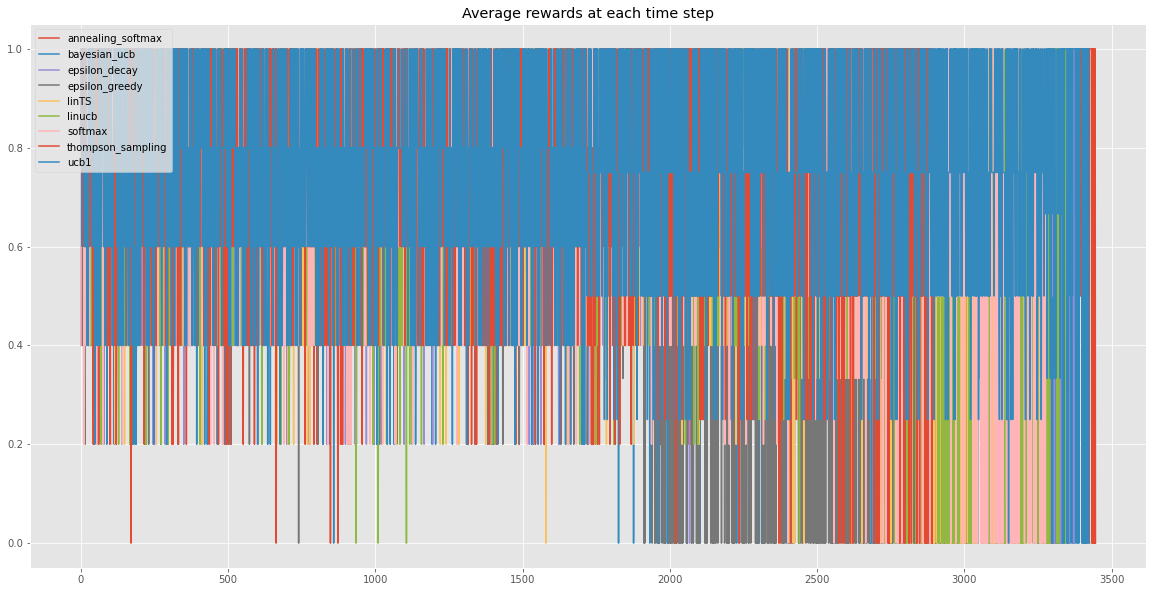

In [35]:
# Plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))

plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

In [36]:
# Determine the cumulative reward at 1000 time step
final_evaluation_ber.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"})

,policy,cumulative_reward
0,annealing_softmax,2609.616667
1,bayesian_ucb,2565.083333
2,epsilon_decay,2574.333333
3,epsilon_greedy,2399.750000
4,linTS,2426.933333
5,linucb,2556.600000
6,softmax,2496.700000
7,thompson_sampling,2165.266667
8,ucb1,2577.883333


Text(0.5, 1.0, 'Cumulative rewards at each step')

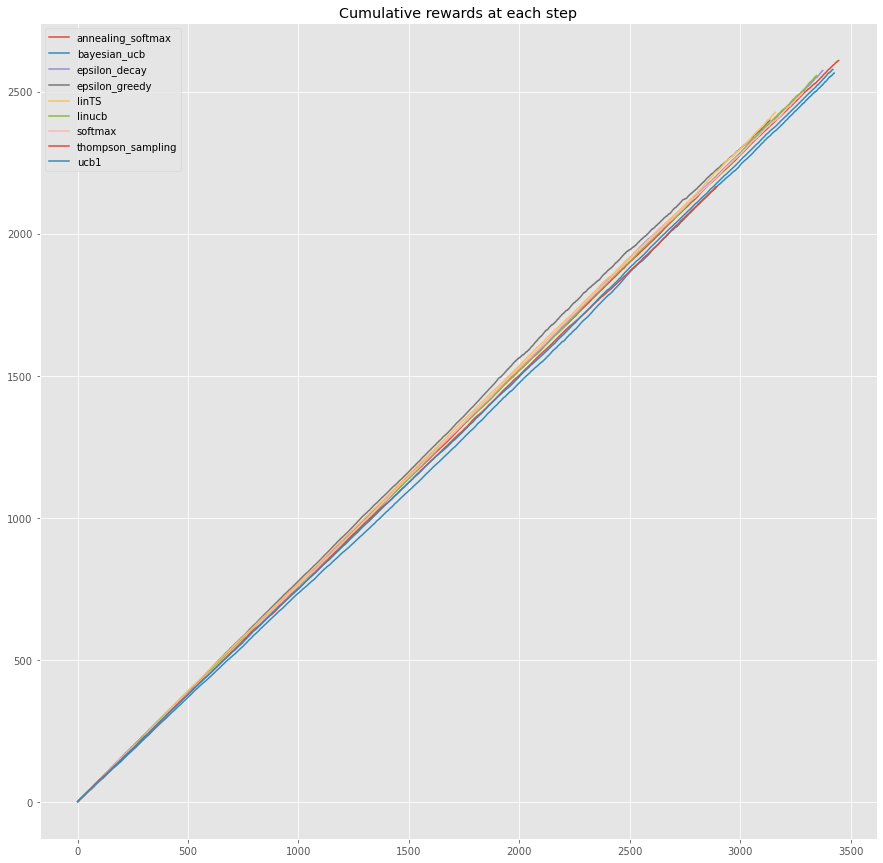

In [37]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

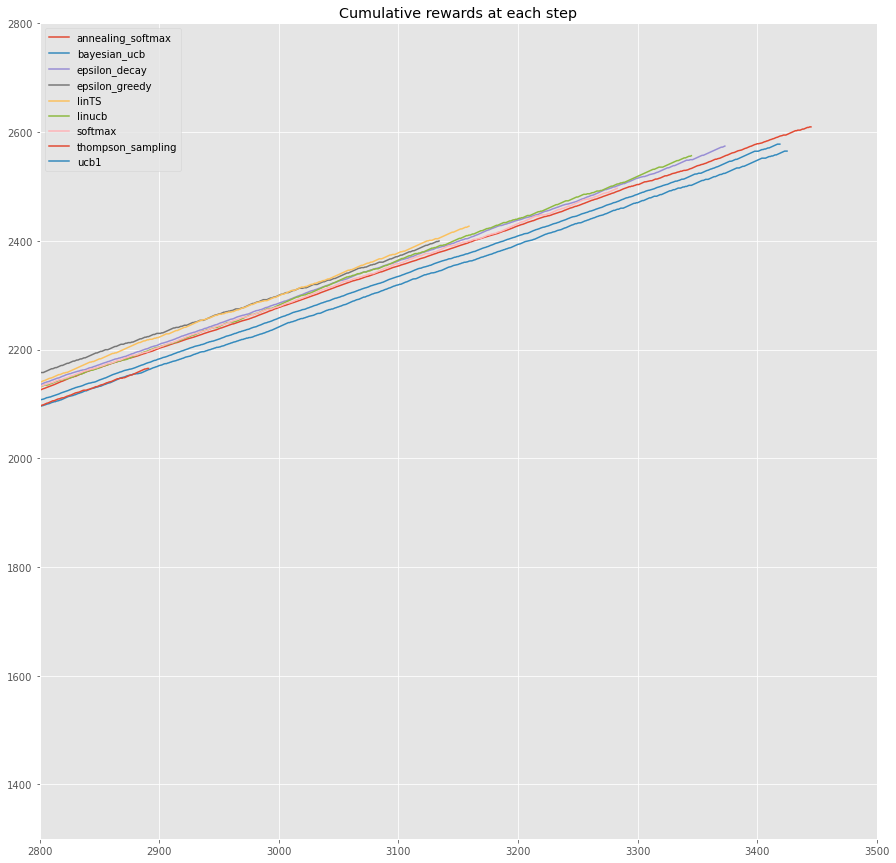

In [38]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.xlim(2800, 3500)
plt.ylim(1300, 2800)
plt.legend()
plt.title("Cumulative rewards at each step")

## Categorical Arm

In [39]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [epsilon_decay, annealing_softmax, ucb1, epsilon_greedy, softmax]
# algos = [annealing_softmax]

# Define a dataframe for evaluation results
evaluation_cat = []

# Define a list to save all arm-play statistics
play_stats = []

count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1
    
    # Count samples
    sample_no = 0

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'mean', 'count', 'cat_dict']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'mean': 'float', 'count': 'float'})
        
        # To keep track of categories count
        categories_dict = {'Dead': 0, 'Alive and still dependent': 0, 'Alive and recovered': 0, 'Alive with unknown status': 0}
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, categories_dict]
        
        step = 0
        sample_no += 1

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 4:
                rec_a = f(container, arms)
            elif count_algos == 4:
                rec_a = f(container, arms, 0.2)
            else:
                rec_a = f(container, arms, 0.1)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (CAT)'] # get the reward value
                regret = 1 - reward
                category = bsample.iloc[i - 1]['REWARD_CATEGORICAL']
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm': action, 'time_step': step, 'sample': sample_no, 'sex': sex, 'age': age, 'reward': reward, 'regret': regret}
                evaluation_cat.append(eva_rec)
                
                # Update reward category
                container['cat_dict'][action - 1][category] = container['cat_dict'][action - 1][category] + 1
                new_estimated_prob = container['cat_dict'][action - 1]['Alive and still dependent'] / sum(container['cat_dict'][action - 1].values())

                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['mean'] = np.where(container['arm'] == action, new_estimated_prob, container['mean'])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [40]:
evaluation_cat = pd.DataFrame(evaluation_cat)
evaluation_cat_policy = evaluation_cat.sort_values(by=['policy','time_step'])
evaluation_cat_policy

,policy,chosen_arm,time_step,sample,sex,age,reward,regret
11134,annealing_softmax,1,1,1,M,OLD,3,-2
13907,annealing_softmax,3,1,2,M,OLD,3,-2
16666,annealing_softmax,2,1,3,M,OLD,4,-3
18900,annealing_softmax,2,1,4,M,YOUNG,3,-2
21193,annealing_softmax,1,1,5,F,YOUNG,4,-3
...,...,...,...,...,...,...,...,...
35291,ucb1,1,3376,4,M,OLD,3,-2
35292,ucb1,1,3377,4,M,YOUNG,3,-2
35293,ucb1,1,3378,4,M,OLD,1,0
35294,ucb1,1,3379,4,M,YOUNG,3,-2


In [41]:
final_evaluation_cat = evaluation_cat_policy.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                                           "regret":"mean"})

final_evaluation_cat['cumulative_reward'] = final_evaluation_cat.groupby(['policy'])['reward'].cumsum()
final_evaluation_cat['cumulative_regret'] = final_evaluation_cat.groupby(['policy'])['regret'].cumsum()
final_evaluation_cat

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,3.4,-2.4,3.400000,-2.400000
1,annealing_softmax,2,4.0,-3.0,7.400000,-5.400000
2,annealing_softmax,3,2.2,-1.2,9.600000,-6.600000
3,annealing_softmax,4,3.6,-2.6,13.200000,-9.200000
4,annealing_softmax,5,2.8,-1.8,16.000000,-11.000000
...,...,...,...,...,...,...
14179,ucb1,3376,3.0,-2.0,9610.766667,-6234.766667
14180,ucb1,3377,3.0,-2.0,9613.766667,-6236.766667
14181,ucb1,3378,1.0,0.0,9614.766667,-6236.766667
14182,ucb1,3379,3.0,-2.0,9617.766667,-6238.766667


In [42]:
evaluation_cat_treatment = evaluation_cat.sort_values(by=['policy', 'sample', 'time_step'])
evaluation_cat_treatment_F = evaluation_cat_treatment[evaluation_cat_treatment['sex'] == 'F']
evaluation_cat_treatment_M = evaluation_cat_treatment[evaluation_cat_treatment['sex'] == 'M']
evaluation_cat_treatment_Y = evaluation_cat_treatment[evaluation_cat_treatment['age'] == 'YOUNG']
evaluation_cat_treatment_O = evaluation_cat_treatment[evaluation_cat_treatment['age'] == 'OLD']

In [43]:
evaluation_cat_groupedtreatment_F = evaluation_cat_treatment_F.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [44]:
evaluation_cat_groupedtreatment_F = evaluation_cat_groupedtreatment_F.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_F

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,2.703913,-1.703913
1,annealing_softmax,2,2.607196,-1.607196
2,annealing_softmax,3,2.749844,-1.749844
3,annealing_softmax,4,2.746645,-1.746645
4,epsilon_decay,1,2.713880,-1.713880
5,epsilon_decay,2,2.706812,-1.706812
6,epsilon_decay,3,2.767269,-1.767269
7,epsilon_decay,4,2.726206,-1.726206
8,epsilon_greedy,1,2.705666,-1.705666
9,epsilon_greedy,2,2.636834,-1.636834


In [45]:
evaluation_cat_groupedtreatment_M = evaluation_cat_treatment_M.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [46]:
evaluation_cat_groupedtreatment_M = evaluation_cat_groupedtreatment_M.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_M

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,2.995168,-1.995168
1,annealing_softmax,2,2.838455,-1.838455
2,annealing_softmax,3,2.959655,-1.959655
3,annealing_softmax,4,3.036555,-2.036555
4,epsilon_decay,1,2.927156,-1.927156
5,epsilon_decay,2,2.812179,-1.812179
6,epsilon_decay,3,2.955346,-1.955346
7,epsilon_decay,4,3.070627,-2.070627
8,epsilon_greedy,1,3.007352,-2.007352
9,epsilon_greedy,2,2.829079,-1.829079


In [47]:
evaluation_cat_groupedtreatment_Y = evaluation_cat_treatment_Y.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [48]:
evaluation_cat_groupedtreatment_Y = evaluation_cat_groupedtreatment_Y.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_Y

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,3.267953,-2.267953
1,annealing_softmax,2,3.099886,-2.099886
2,annealing_softmax,3,3.177663,-2.177663
3,annealing_softmax,4,3.176338,-2.176338
4,epsilon_decay,1,3.203023,-2.203023
5,epsilon_decay,2,3.195010,-2.195010
6,epsilon_decay,3,3.205174,-2.205174
7,epsilon_decay,4,3.194027,-2.194027
8,epsilon_greedy,1,3.279546,-2.279546
9,epsilon_greedy,2,3.118283,-2.118283


In [49]:
evaluation_cat_groupedtreatment_O = evaluation_cat_treatment_O.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [50]:
evaluation_cat_groupedtreatment_O = evaluation_cat_groupedtreatment_O.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_O

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,2.604725,-1.604725
1,annealing_softmax,2,2.528026,-1.528026
2,annealing_softmax,3,2.678398,-1.678398
3,annealing_softmax,4,2.714960,-1.714960
4,epsilon_decay,1,2.586414,-1.586414
5,epsilon_decay,2,2.511492,-1.511492
6,epsilon_decay,3,2.650695,-1.650695
7,epsilon_decay,4,2.720264,-1.720264
8,epsilon_greedy,1,2.618936,-1.618936
9,epsilon_greedy,2,2.534573,-1.534573


## Test Stats

### Comparing between Algorithms
Is there a difference in performance between the different multi-armed bandit algorithms?

In [51]:
epsilon_greedy_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'ucb1']['reward'])

f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, linucb_rewards)

F_onewayResult(statistic=8283.048114046487, pvalue=0.0)

In [52]:
tukey_df_algo_cat = final_evaluation_cat[['policy', 'reward']]

tukey_algo_cat = pairwise_tukeyhsd(endog=tukey_df_algo_cat['reward'],
                                   groups=tukey_df_algo_cat['policy'],
                                   alpha=0.05)

In [53]:
print(tukey_algo_cat)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2     meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------
annealing_softmax  epsilon_decay   0.0038 0.9992 -0.0386 0.0461  False
annealing_softmax epsilon_greedy   0.0088 0.9811 -0.0345 0.0522  False
annealing_softmax        softmax   0.0194 0.7386  -0.024 0.0629  False
annealing_softmax           ucb1  -0.0015    1.0 -0.0422 0.0392  False
    epsilon_decay epsilon_greedy   0.0051 0.9977  -0.038 0.0481  False
    epsilon_decay        softmax   0.0157 0.8596 -0.0275 0.0588  False
    epsilon_decay           ucb1  -0.0052 0.9966 -0.0457 0.0352  False
   epsilon_greedy        softmax   0.0106 0.9656 -0.0335 0.0547  False
   epsilon_greedy           ucb1  -0.0103 0.9607 -0.0517 0.0311  False
          softmax           ucb1  -0.0209 0.6433 -0.0624 0.0206  False
----------------------------------------------------------------------


### Comparing for Treatments 
For each treatment method, is there a difference in performance between different age groups or different sex?


In [54]:
evaluation_cat_groupedtreatment_F1 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_F2 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_F3 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_F4 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 4]

evaluation_cat_groupedtreatment_M1 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_M2 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_M3 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_M4 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 4]

In [55]:
sex_1 = ttest_ind(evaluation_cat_groupedtreatment_F1['reward'], evaluation_cat_groupedtreatment_M1['reward'])
sex_2 = ttest_ind(evaluation_cat_groupedtreatment_F2['reward'], evaluation_cat_groupedtreatment_M2['reward'])
sex_3 = ttest_ind(evaluation_cat_groupedtreatment_F3['reward'], evaluation_cat_groupedtreatment_M3['reward'])
sex_4 = ttest_ind(evaluation_cat_groupedtreatment_F4['reward'], evaluation_cat_groupedtreatment_M4['reward'])
print(f'Treatment 1 (sex): {sex_1}')
print(f'Treatment 2 (sex): {sex_2}')
print(f'Treatment 3 (sex): {sex_3}')
print(f'Treatment 4 (sex): {sex_4}')

Treatment 1 (sex): Ttest_indResult(statistic=-0.9162916510459042, pvalue=0.38630173997157313)
Treatment 2 (sex): Ttest_indResult(statistic=-2.5017433560466618, pvalue=0.03684182343642366)
Treatment 3 (sex): Ttest_indResult(statistic=-3.7191149580420397, pvalue=0.005878865807505109)
Treatment 4 (sex): Ttest_indResult(statistic=-2.319801176300344, pvalue=0.04893461483166566)


In [56]:
evaluation_cat_groupedtreatment_Y1 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_Y2 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_Y3 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_Y4 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 4]

evaluation_cat_groupedtreatment_O1 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_O2 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_O3 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_O4 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 4]

In [57]:
age_1 = ttest_ind(evaluation_cat_groupedtreatment_Y1['reward'], evaluation_cat_groupedtreatment_O1['reward'])
age_2 = ttest_ind(evaluation_cat_groupedtreatment_Y2['reward'], evaluation_cat_groupedtreatment_O2['reward'])
age_3 = ttest_ind(evaluation_cat_groupedtreatment_Y3['reward'], evaluation_cat_groupedtreatment_O3['reward'])
age_4 = ttest_ind(evaluation_cat_groupedtreatment_Y4['reward'], evaluation_cat_groupedtreatment_O4['reward'])
print(f'Treatment 1 (age): {age_1}')
print(f'Treatment 2 (age): {age_2}')
print(f'Treatment 3 (age): {age_3}')
print(f'Treatment 4 (age): {age_4}')

Treatment 1 (age): Ttest_indResult(statistic=9.447948523820333, pvalue=1.2948747311493905e-05)
Treatment 2 (age): Ttest_indResult(statistic=7.104846297360127, pvalue=0.0001015060918004297)
Treatment 3 (age): Ttest_indResult(statistic=4.039831553555596, pvalue=0.0037366207693084463)
Treatment 4 (age): Ttest_indResult(statistic=2.260118280306493, pvalue=0.0537124486525094)


## Reward

Text(0.5, 1.0, 'Average rewards at each time step')

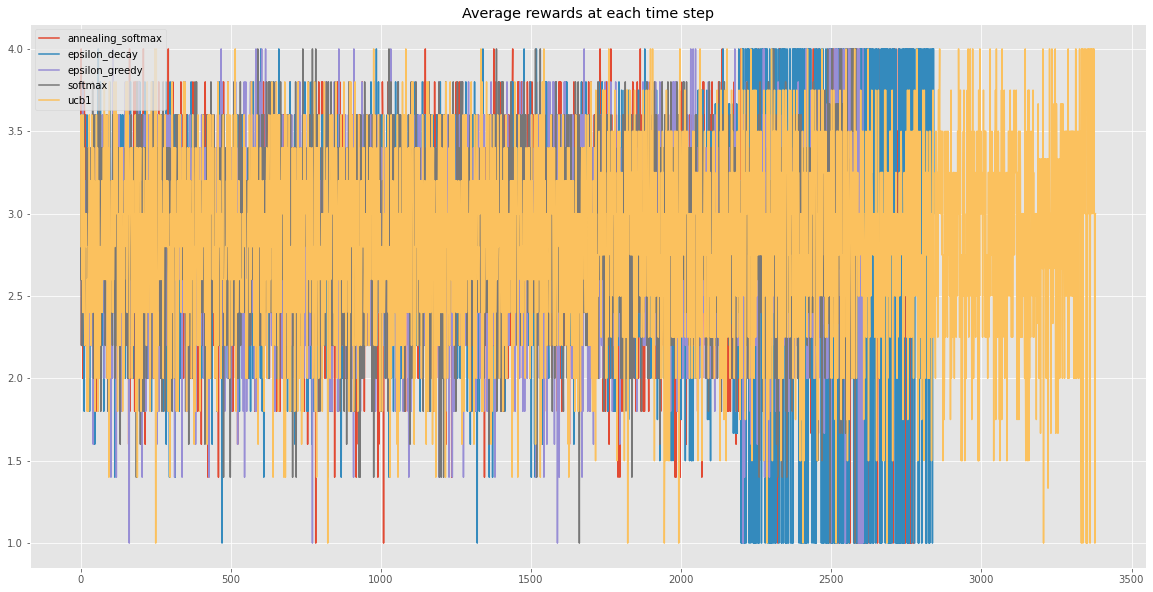

In [58]:
# Plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))
plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

In [59]:
# Determine the cumulative reward at 1000 time step
final_evaluation_cat.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"})

,policy,cumulative_reward
0,annealing_softmax,7897.116667
1,epsilon_decay,8104.333333
2,epsilon_greedy,7444.583333
3,softmax,7406.250000
4,ucb1,9620.766667


Text(0.5, 1.0, 'Cumulative rewards at each step')

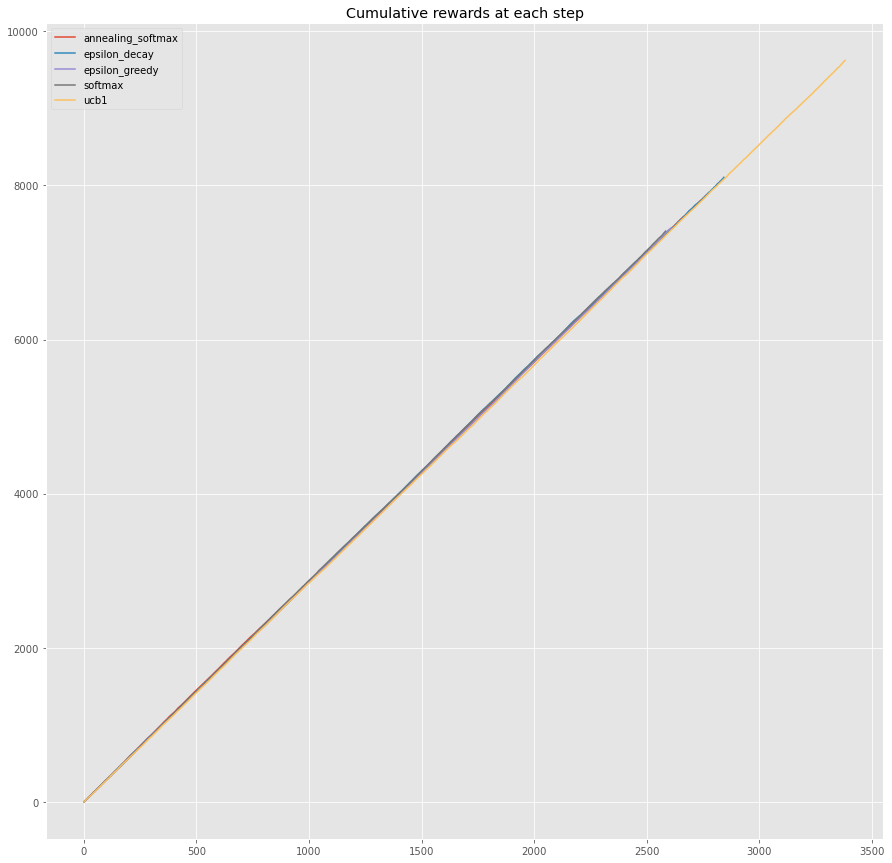

In [60]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

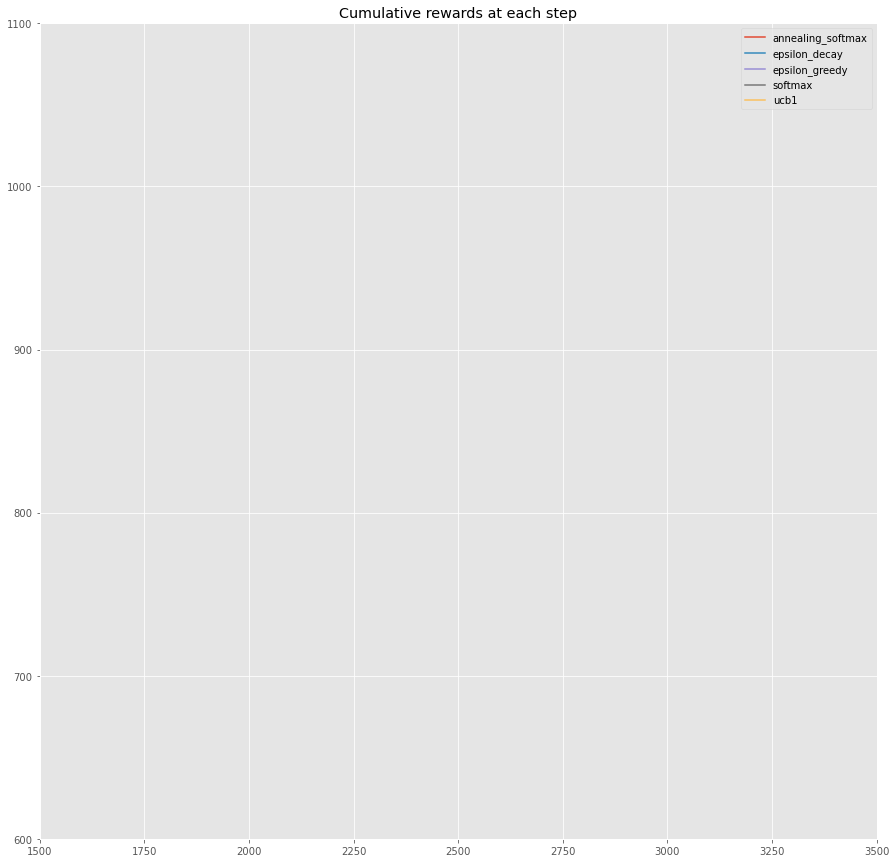

In [61]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))
    
plt.xlim(1500, 3500)
plt.ylim(600, 1100)
plt.legend()
plt.title("Cumulative rewards at each step")